In [1]:
import sys
import datetime as dt
from copy import deepcopy
from os import getcwd
from os.path import dirname, join

import rioxarray as rxr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import cm
import pytz
from rasterio.enums import Resampling
from scipy import interpolate

PROJ_DIR = dirname(getcwd())
sys.path.append(PROJ_DIR)

SRC_DIR = join(PROJ_DIR, 'MAMMAL')
DATA_DIR = join(PROJ_DIR, 'data')
TEST_DIR = join(DATA_DIR, 'test')

import MAMMAL
from MAMMAL.Parse import parseSGL as psgl
from MAMMAL.Utils import mapUtils as mu
from MAMMAL.Utils import ProcessingUtils as pu


%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 10) # (w, h)
pd.set_option('mode.chained_assignment', None)


CORDS_FNAME  = join(TEST_DIR, 'CORDS-Road_MAG-asc.gxf')            # Cords Road: 300m MSL (map is level)
MEDIUM_FNAME = join(TEST_DIR, 'R2508-Medium-Altitude_MAG-asc.gxf') # Medium altitude: 7000m MSL (map is level)
CAP_FNAME    = join(TEST_DIR, 'R2508-Cap_MAG-asc.gxf')             # Cap altitude: 17000m MSL (map is level)

CORDS_SURVEY_FNAME  = join(TEST_DIR, 'CORDS-Road_channels.xyz')
MEDIUM_SURVEY_FNAME = join(TEST_DIR, 'R2508-Medium-Altitude_channels.xyz')
CAP_SURVEY_FNAME    = join(TEST_DIR, 'R2508-Cap_channels.xyz')

CORDS_SURVEY_NAME  = 'CORDS-Road'
MEDIUM_SURVEY_NAME = 'R2508-Medium-Altitude'
CAP_SURVEY_NAME    = 'R2508-Cap'


def init_xyz_plots(df, survey_name):
    fl_mask = df.LINE_TYPE == 1
    
    plt.figure()
    plt.title('SGL Raw Samples\n{} - SGL'.format(survey_name))
    plt.scatter(df.LONG,
                df.LAT,
                c=df.UNCOMPMAG, s=1, cmap=cm.coolwarm)
    plt.xlabel('Longitude (dd)')
    plt.xlabel('Latitude (dd)')
    plt.colorbar(label='nT')

    plt.figure()
    plt.title('Compensation Magnitudes\n{} - SGL'.format(survey_name))
    plt.scatter(df.LONG,
                df.LAT,
                c=df.COMPMAG - df.UNCOMPMAG, s=1, cmap=cm.coolwarm)
    plt.xlabel('Longitude (dd)')
    plt.xlabel('Latitude (dd)')
    plt.colorbar(label='nT')

    plt.figure()
    plt.title('SGL Samples with Compensation\n{} - SGL'.format(survey_name))
    plt.scatter(df.LONG,
                df.LAT,
                c=df.COMPMAG, s=1, cmap=cm.coolwarm)
    plt.xlabel('Longitude (dd)')
    plt.xlabel('Latitude (dd)')
    plt.colorbar(label='nT')

    plt.figure()
    plt.title('Temporal Variation Magnitudes\n{} - SGL'.format(survey_name))
    plt.scatter(df.LONG,
                df.LAT,
                c=df.UNCOMPMAG - df.DCMAG, s=1, cmap=cm.coolwarm)
    plt.xlabel('Longitude (dd)')
    plt.xlabel('Latitude (dd)')
    plt.colorbar(label='nT')

    plt.figure()
    plt.title('SGL Samples with Compensation\\Diurnal Corrections\n{} - SGL'.format(survey_name))
    plt.scatter(df.LONG,
                df.LAT,
                c=df.DCMAG, s=1, cmap=cm.coolwarm)
    plt.xlabel('Longitude (dd)')
    plt.xlabel('Latitude (dd)')
    plt.colorbar(label='nT')

    plt.figure()
    plt.title('IGRF Magnitudes\n{} - SGL'.format(survey_name))
    plt.scatter(df.LONG,
                df.LAT,
                c=df.DCMAG - df.IGRFMAG, s=1, cmap=cm.coolwarm)
    plt.xlabel('Longitude (dd)')
    plt.xlabel('Latitude (dd)')
    plt.colorbar(label='nT')

    plt.figure()
    plt.title('SGL Samples with Compensation\\Diurnal\\IGRF Corrections\n{} - SGL'.format(survey_name))
    plt.scatter(df.LONG,
                df.LAT,
                c=df.IGRFMAG, s=1, cmap=cm.coolwarm)
    plt.xlabel('Longitude (dd)')
    plt.xlabel('Latitude (dd)')
    plt.colorbar(label='nT')

    plt.figure()
    plt.title('Leveling Correction Magnitudes\n{} - SGL'.format(survey_name))
    plt.scatter(df[fl_mask].LONG,
                df[fl_mask].LAT,
                c=df[fl_mask].IGRFMAG - df[fl_mask].F, s=1, cmap=cm.coolwarm)
    plt.xlabel('Longitude (dd)')
    plt.xlabel('Latitude (dd)')
    plt.colorbar(label='nT')

    plt.figure()
    plt.title('SGL Samples with Compensation\\Diurnal\\IGRF\\Leveling Corrections\n{} - SGL'.format(survey_name))
    plt.scatter(df[fl_mask].LONG,
                df[fl_mask].LAT,
                c=df[fl_mask].F, s=1, cmap=cm.coolwarm)
    plt.xlabel('Longitude (dd)')
    plt.xlabel('Latitude (dd)')
    plt.colorbar(label='nT')

# Load and Plot SGL Maps

Text(0.5, 1.0, 'SGL Cap Altitude Map')

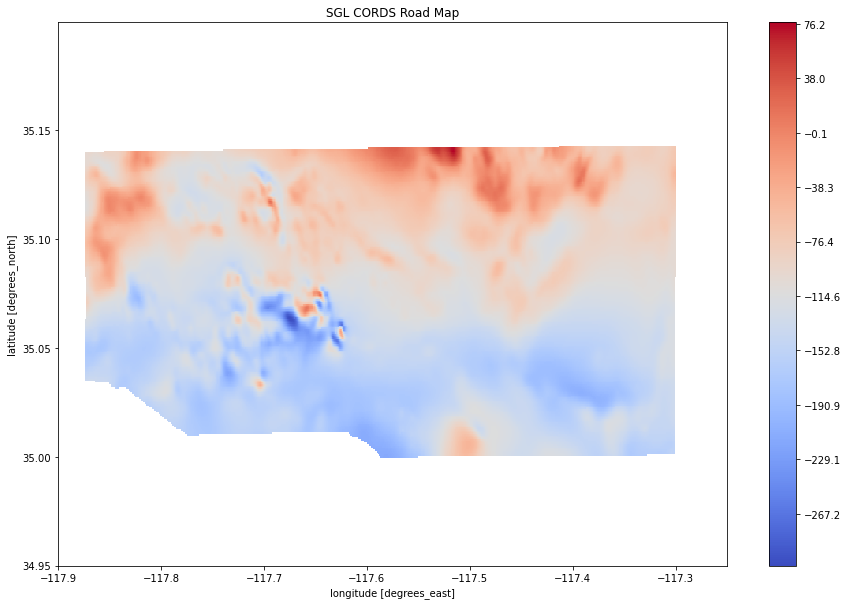

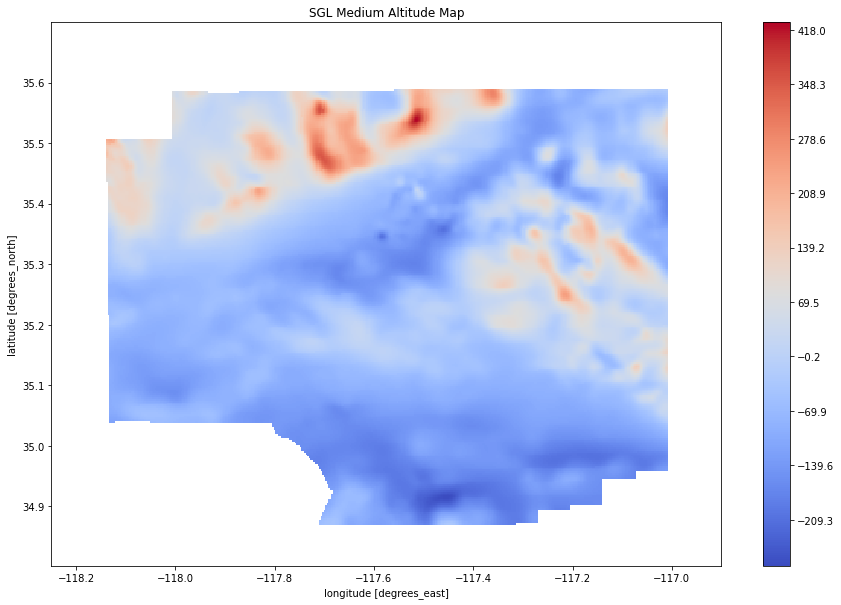

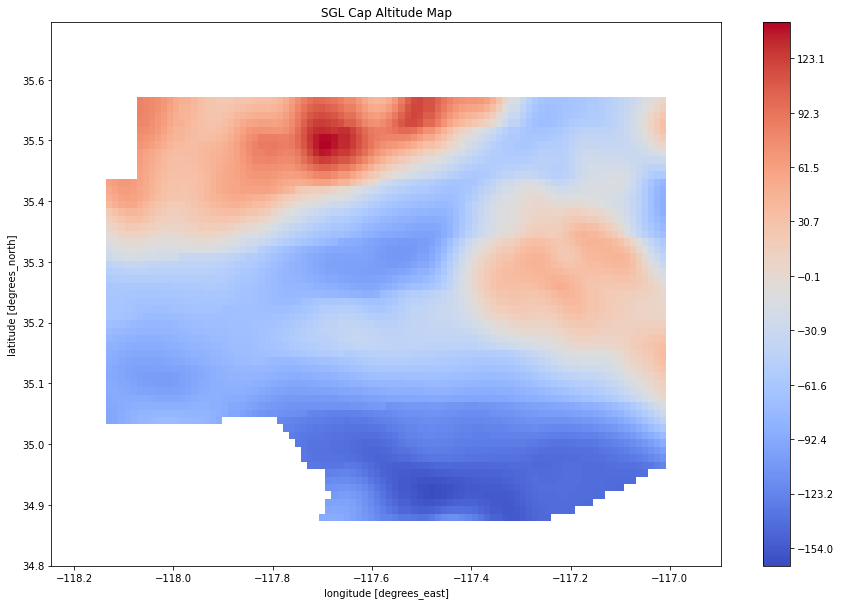

In [2]:
# TM: Transverse Mercador
cords_map_tm  = rxr.open_rasterio(CORDS_FNAME,  masked=True, decode_coords='all')
medium_map_tm = rxr.open_rasterio(MEDIUM_FNAME, masked=True, decode_coords='all')
cap_map_tm    = rxr.open_rasterio(CAP_FNAME,    masked=True, decode_coords='all')

cords_map  = cords_map_tm.rio.reproject("EPSG:4326", resample=Resampling.cubic_spline)
medium_map = medium_map_tm.rio.reproject("EPSG:4326", resample=Resampling.cubic_spline)
cap_map    = cap_map_tm.rio.reproject("EPSG:4326", resample=Resampling.cubic_spline)


mask_lon  = (cords_map.x >= -117.9) & (cords_map.x <= -117.25)
mask_lat  = (cords_map.y >= 34.95)  & (cords_map.y <= 35.2)
cords_map = cords_map.where(mask_lon & mask_lat, drop=True)


mask_lon   = (medium_map.x >= -118.25) & (medium_map.x <= -116.9)
mask_lat   = (medium_map.y >= 34.8)    & (medium_map.y <= 35.7)
medium_map = medium_map.where(mask_lon & mask_lat, drop=True)


mask_lon = (cap_map.x >= -118.25) & (cap_map.x <= -116.9)
mask_lat = (cap_map.y >= 34.8)    & (cap_map.y <= 35.7)
cap_map  = cap_map.where(mask_lon & mask_lat, drop=True)


cords_min  = cords_map[0].data[~np.isnan(cords_map[0].data)].min() - 1
cords_max  = cords_map[0].data[~np.isnan(cords_map[0].data)].max() + 1
cords_lvls = np.linspace(cords_min, cords_max, 1000)

medium_min  = medium_map[0].data[~np.isnan(medium_map[0].data)].min() - 1
medium_max  = medium_map[0].data[~np.isnan(medium_map[0].data)].max() + 1
medium_lvls = np.linspace(medium_min, medium_max, 1000)

cap_min  = cap_map[0].data[~np.isnan(cap_map[0].data)].min() - 1
cap_max  = cap_map[0].data[~np.isnan(cap_map[0].data)].max() + 1
cap_lvls = np.linspace(cap_min, cap_max, 1000)


plt.figure()
cords_map.plot(cmap=cm.coolwarm, levels=cords_lvls)
plt.title('SGL CORDS Road Map')

plt.figure()
medium_map.plot(cmap=cm.coolwarm, levels=medium_lvls)
plt.title('SGL Medium Altitude Map')

plt.figure()
cap_map.plot(cmap=cm.coolwarm, levels=cap_lvls)
plt.title('SGL Cap Altitude Map')

# Load and Plot SGL Raw Survey Data - CORDS Road

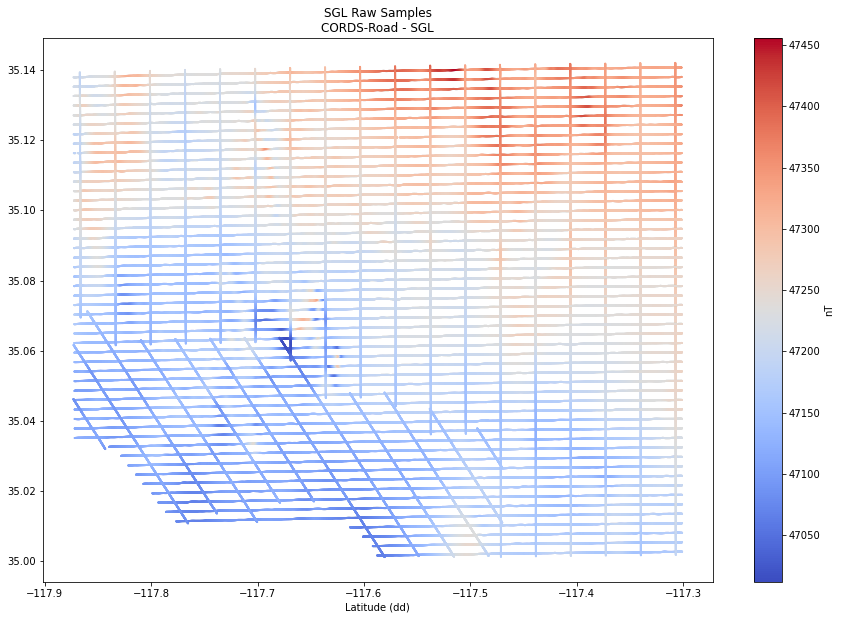

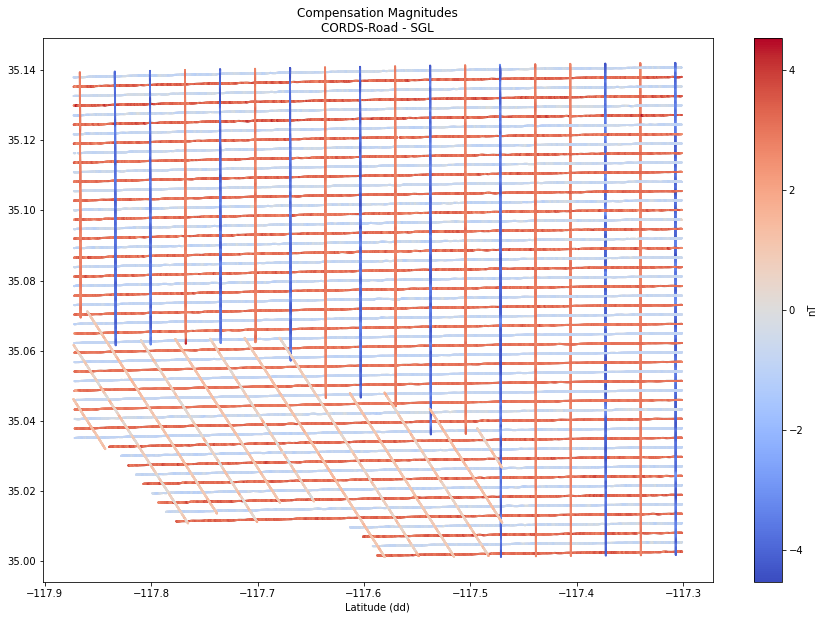

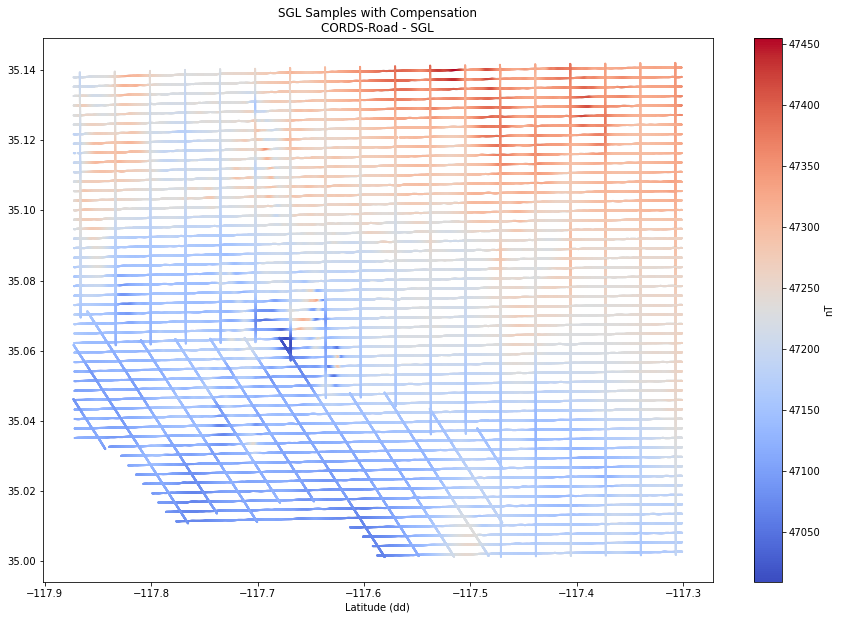

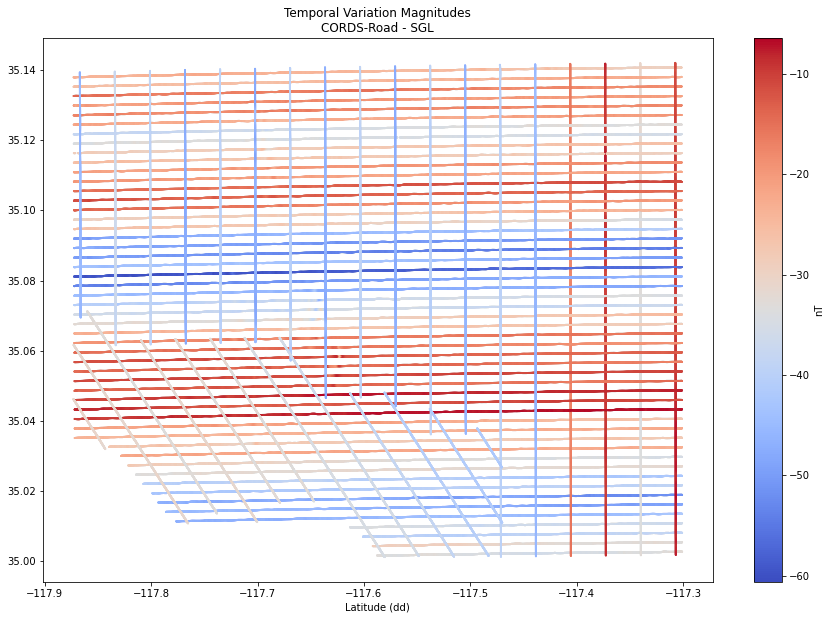

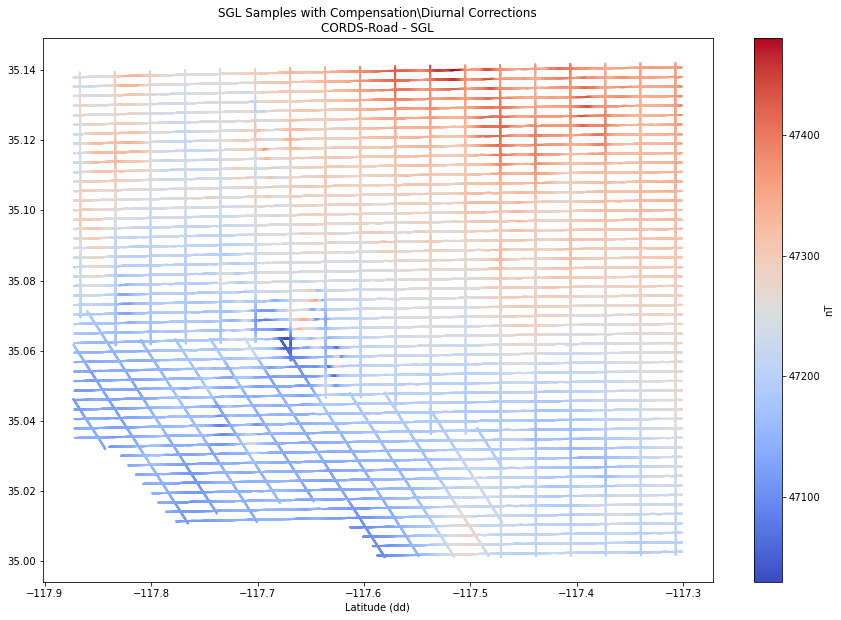

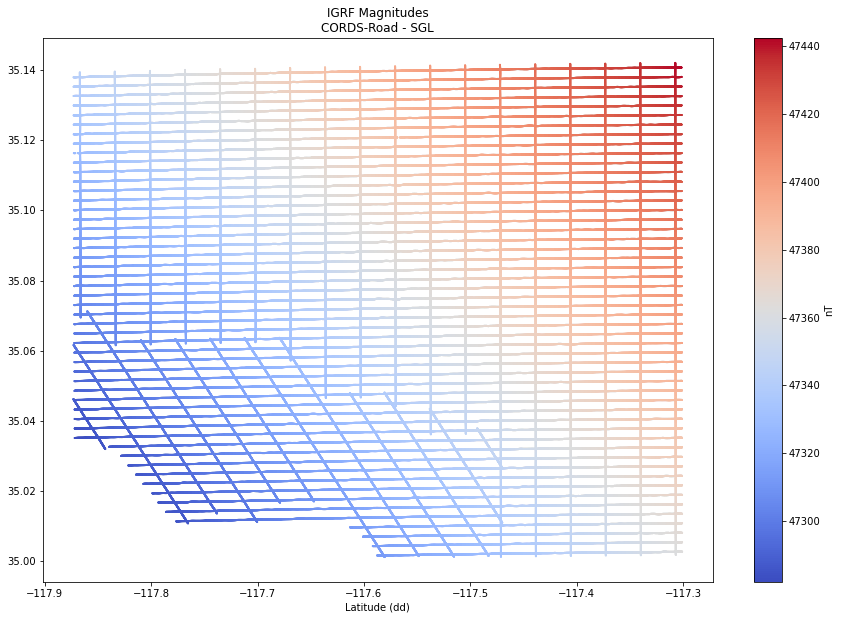

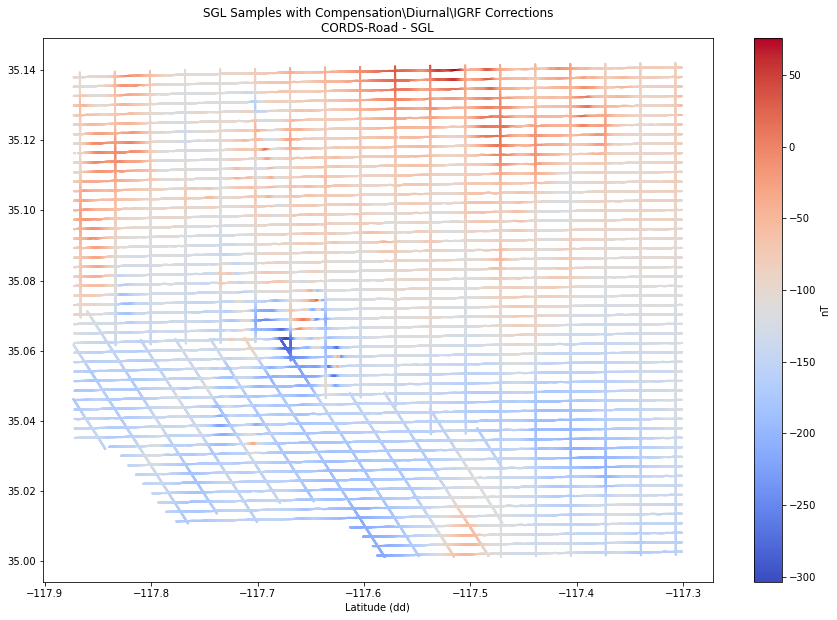

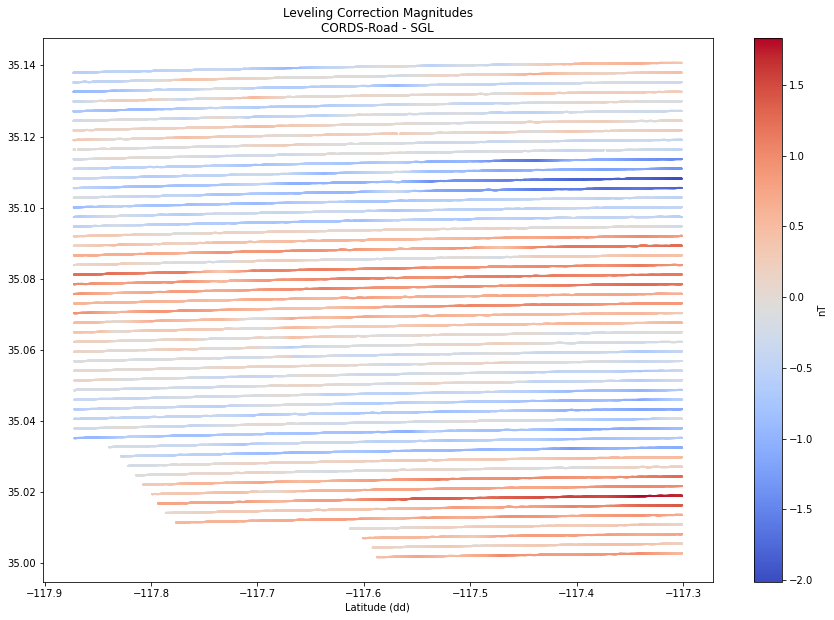

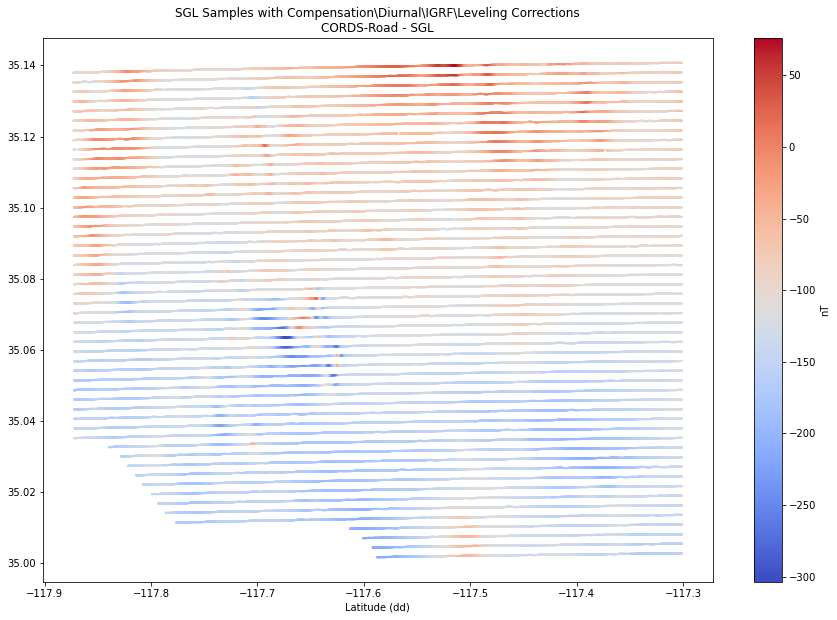

In [3]:
cords_df = psgl.parse_xyz(CORDS_SURVEY_FNAME)

cords_df.rename(columns={'LVLDMAG': 'F'},
                inplace=True)

cords_df['ALT']       = 0
cords_df['LINE_TYPE'] = 2
cords_df.LINE_TYPE[((cords_df.AZIMUTH >= 80)  & (cords_df.AZIMUTH <= 100)) | \
                   ((cords_df.AZIMUTH >= 260) & (cords_df.AZIMUTH <= 280))] = 1

init_xyz_plots(cords_df, CORDS_SURVEY_NAME)

# MAMMAL Interpolate SGL Raw Data - CORDS Road

In [12]:
cords_interp_dict = pu.interp_flight_lines(anomaly_df      = cords_df,
                                           dx              = abs(np.mean(np.diff(cords_map_tm.x))),
                                           dy              = abs(np.mean(np.diff(cords_map_tm.y))),
                                           max_terrain_msl = 0,
                                           interp_type     = 'bicubic',
                                           skip_na_mask    = True)

mammal_cords_map = mu.export_map(TEST_DIR,
                                 CORDS_SURVEY_NAME + '_mammal',
                                 cords_df.datetime[0],
                                 np.sort(np.unique(cords_interp_dict['LAT'])),
                                 np.sort(np.unique(cords_interp_dict['LONG'])),
                                 cords_interp_dict['F'],
                                 0)

Interpolating survey anomaly data to map coordinates
Running bicubic spline interpolation for all map pixels


# Compare MAMMAL Interpolated Map Vs SGL Map - CORDS Road

C:\Users\ltber\Anaconda3\Lib\site-packages\xarray\core\missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
C:\Users\ltber\Anaconda3\Lib\site-packages\xarray\core\missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
C:\Users\ltber\Anaconda3\Lib\site-packages\xarray\core\missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
C:\Users\ltber\Anaconda3\Lib\site-packages\xarray\core\missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. 

Text(0.5, 1.0, 'Difference Between SGL and MAMMAL CORDS Road Maps')

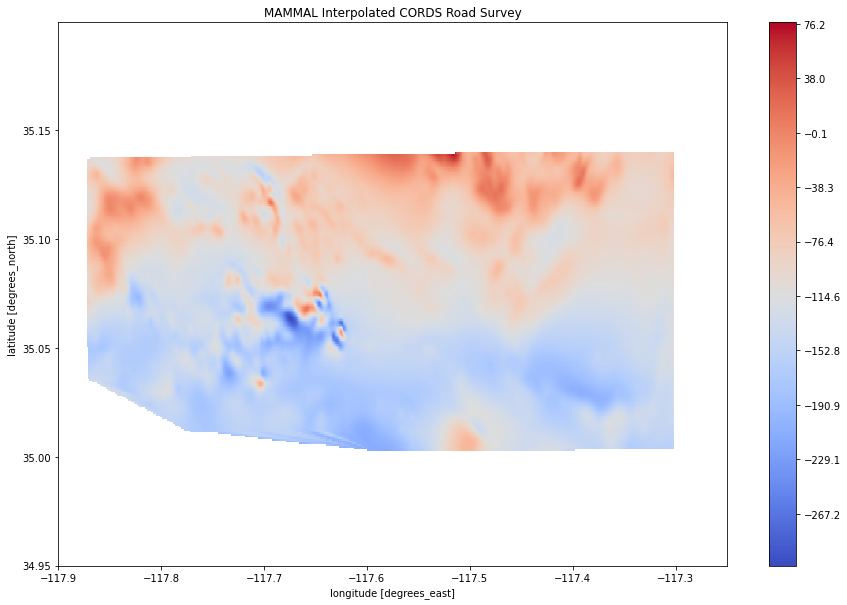

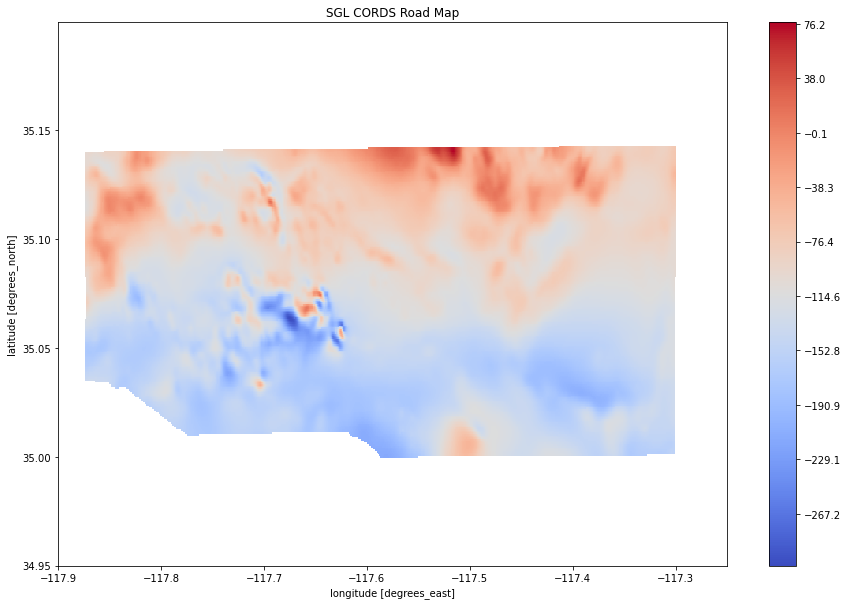

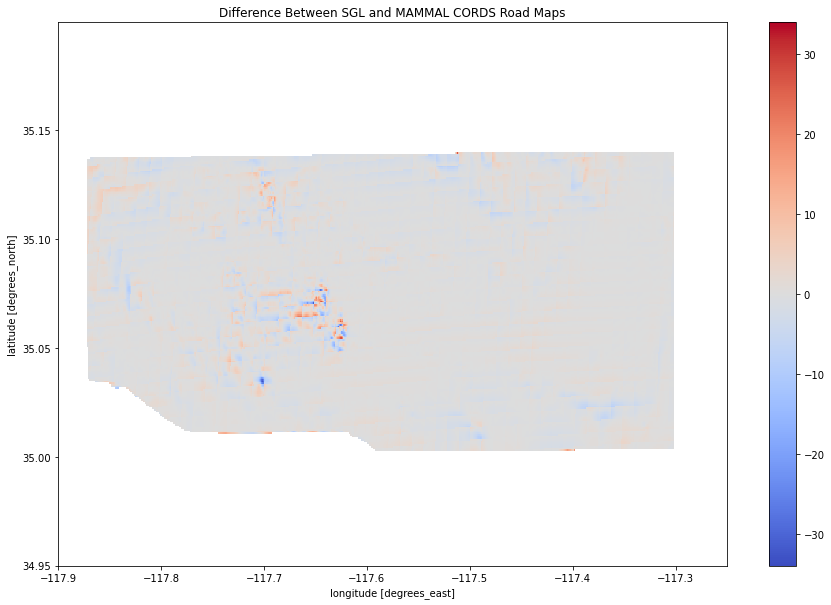

In [13]:
mammal_cords_map = mammal_cords_map.interp(x=cords_map.x, y=cords_map.y)

plt.figure()
mammal_cords_map[0].plot(cmap=cm.coolwarm, levels=cords_lvls)
plt.title('MAMMAL Interpolated CORDS Road Survey')

plt.figure()
cords_map.plot(cmap=cm.coolwarm, levels=cords_lvls)
plt.title('SGL CORDS Road Map')

plt.figure()
(cords_map[0] - mammal_cords_map[0]).plot(cmap=cm.coolwarm)
plt.title('Difference Between SGL and MAMMAL CORDS Road Maps')

# Load and Plot SGL Raw Survey Data - Medium Altitude

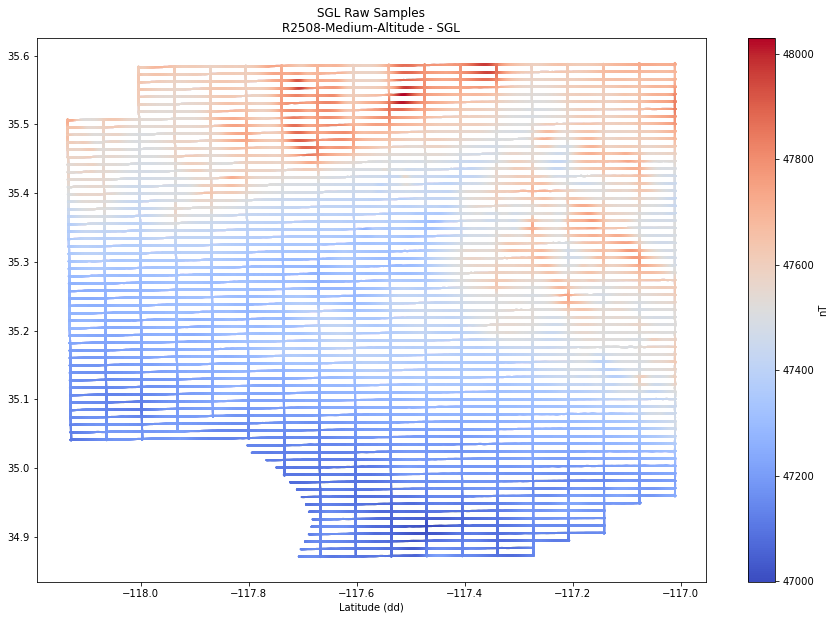

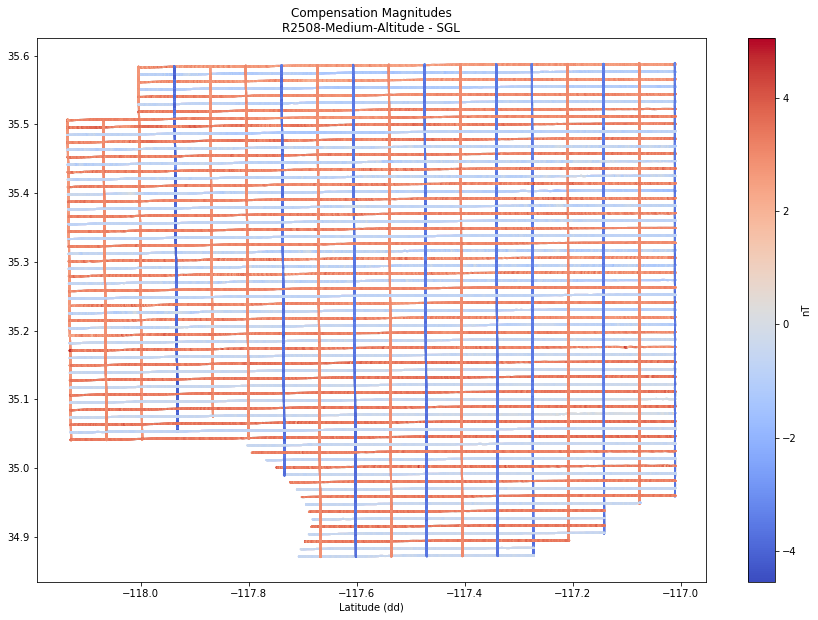

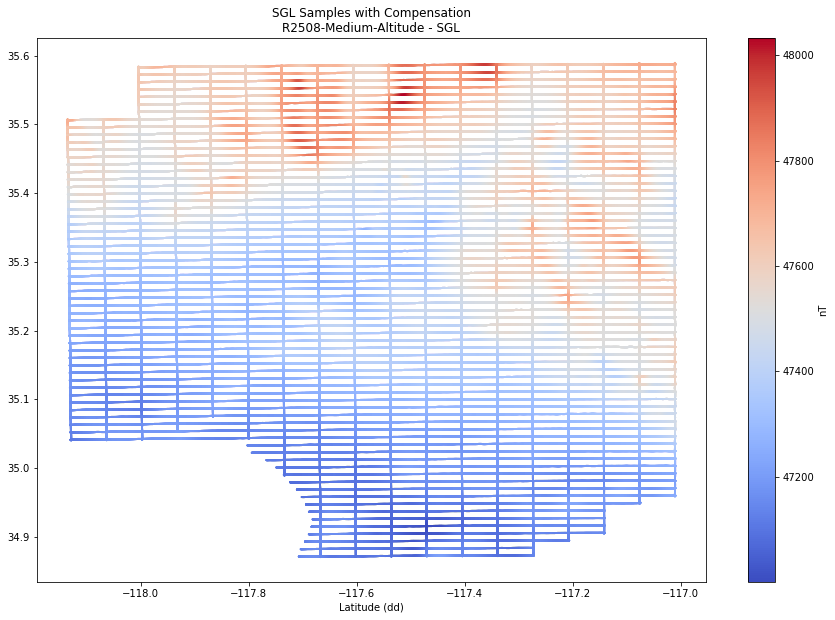

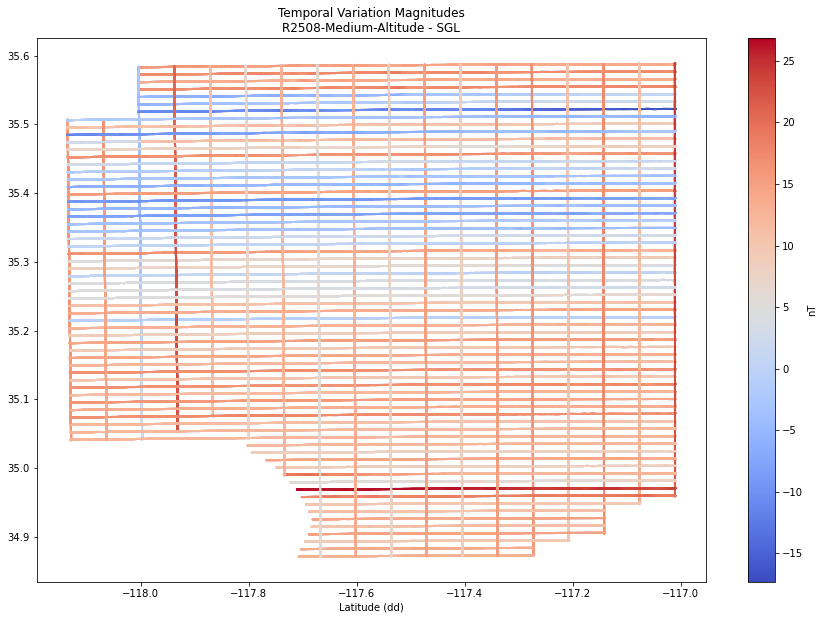

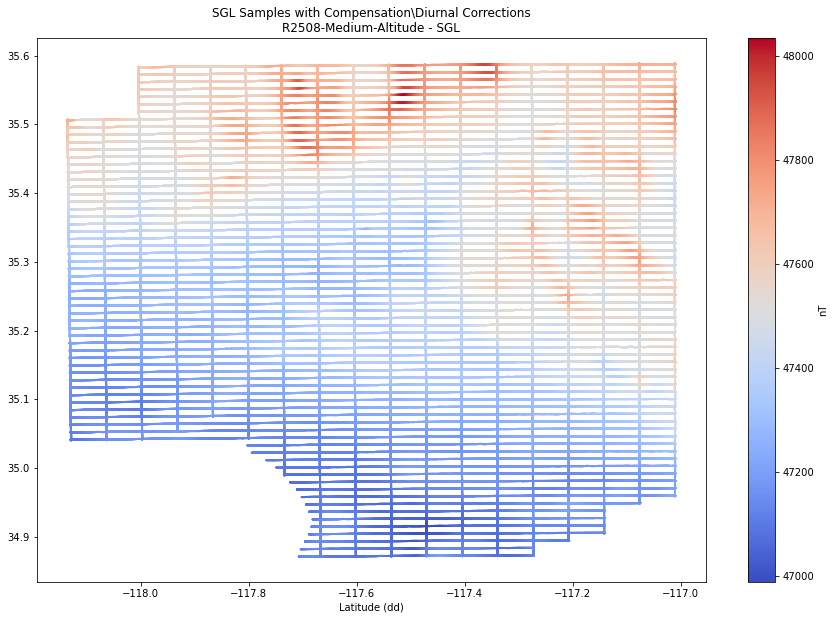

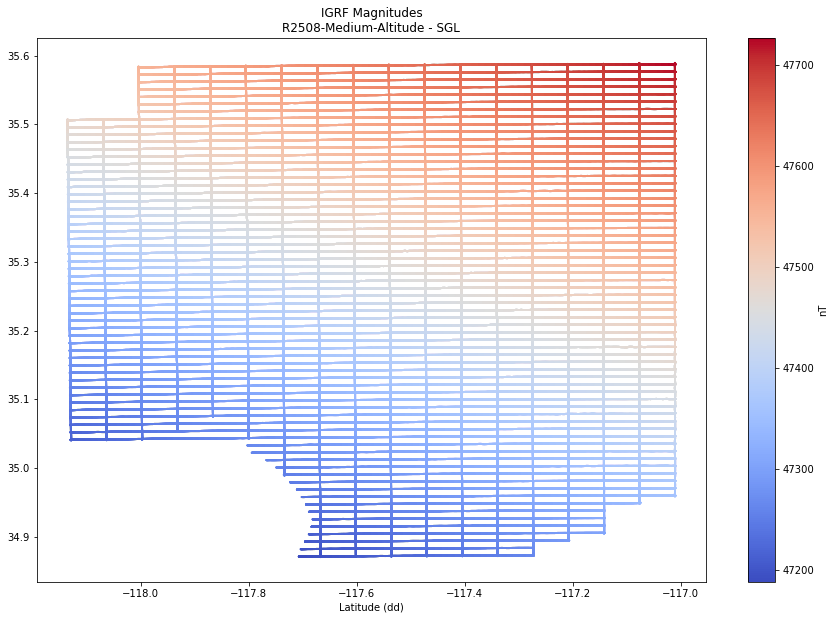

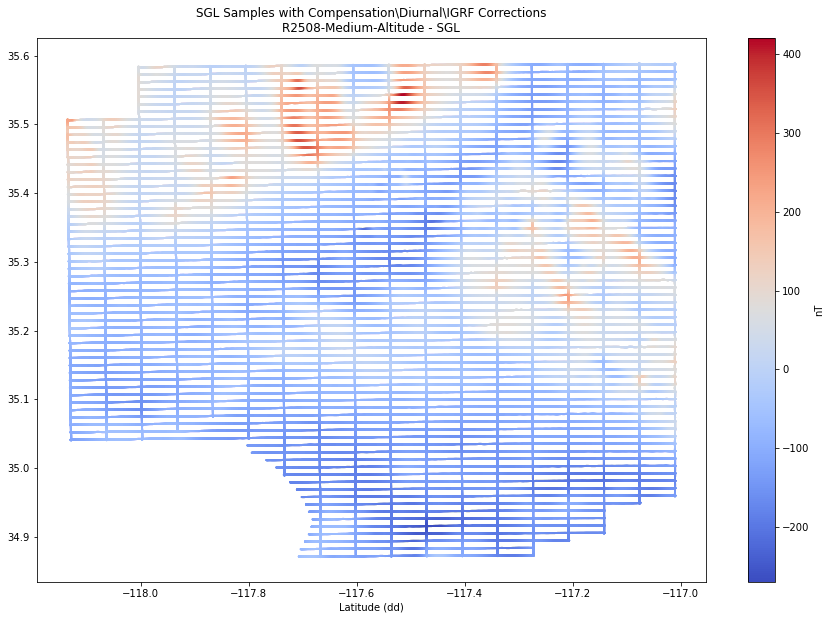

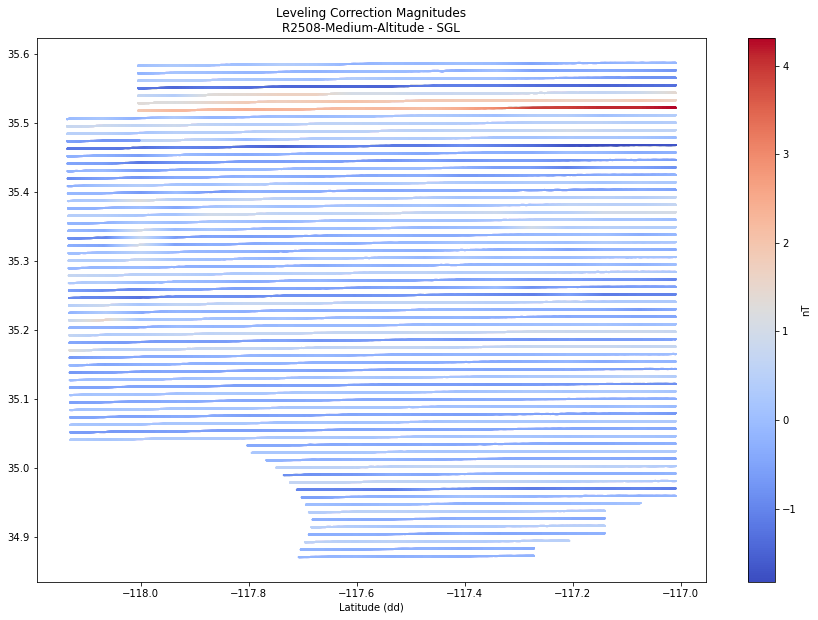

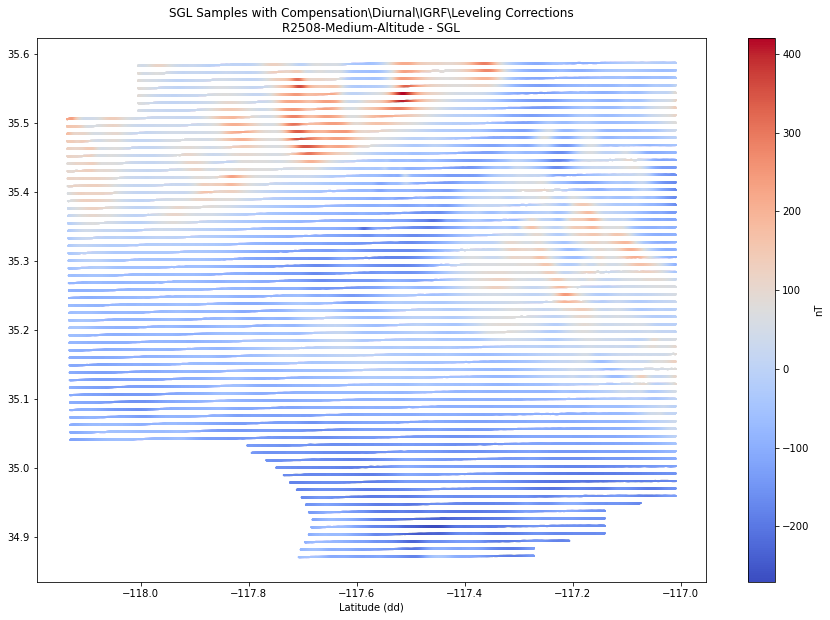

In [6]:
medium_df = psgl.parse_xyz(MEDIUM_SURVEY_FNAME)

medium_df.rename(columns={'LVLDMAG': 'F'},
                inplace=True)

medium_df['ALT']       = 0
medium_df['LINE_TYPE'] = 2
medium_df.LINE_TYPE[((medium_df.AZIMUTH >= 75)  & (medium_df.AZIMUTH <= 105)) | \
                    ((medium_df.AZIMUTH >= 250) & (medium_df.AZIMUTH <= 280))] = 1

init_xyz_plots(medium_df, MEDIUM_SURVEY_NAME)

# MAMMAL Interpolate SGL Raw Data - Medium Altitude

In [7]:
medium_interp_dict = pu.interp_flight_lines(anomaly_df      = medium_df,
                                            dx              = abs(np.mean(np.diff(medium_map_tm.x))),
                                            dy              = abs(np.mean(np.diff(medium_map_tm.y))),
                                            max_terrain_msl = 0,
                                            interp_type     = 'bicubic',
                                            skip_na_mask    = True)

mammal_medium_map = mu.export_map(TEST_DIR,
                                  MEDIUM_SURVEY_NAME + '_mammal',
                                  medium_df.datetime[0],
                                  np.sort(np.unique(medium_interp_dict['LAT'])),
                                  np.sort(np.unique(medium_interp_dict['LONG'])),
                                  medium_interp_dict['F'],
                                  0)

Interpolating survey anomaly data to map coordinates
Running bicubic spline interpolation for all map pixels


# Compare MAMMAL Interpolated Map Vs SGL Map - Medium Altitude

C:\Users\ltber\Anaconda3\Lib\site-packages\xarray\core\missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
C:\Users\ltber\Anaconda3\Lib\site-packages\xarray\core\missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
C:\Users\ltber\Anaconda3\Lib\site-packages\xarray\core\missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
C:\Users\ltber\Anaconda3\Lib\site-packages\xarray\core\missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. 

Text(0.5, 1.0, 'Difference Between SGL and MAMMAL Medium Altitude Maps')

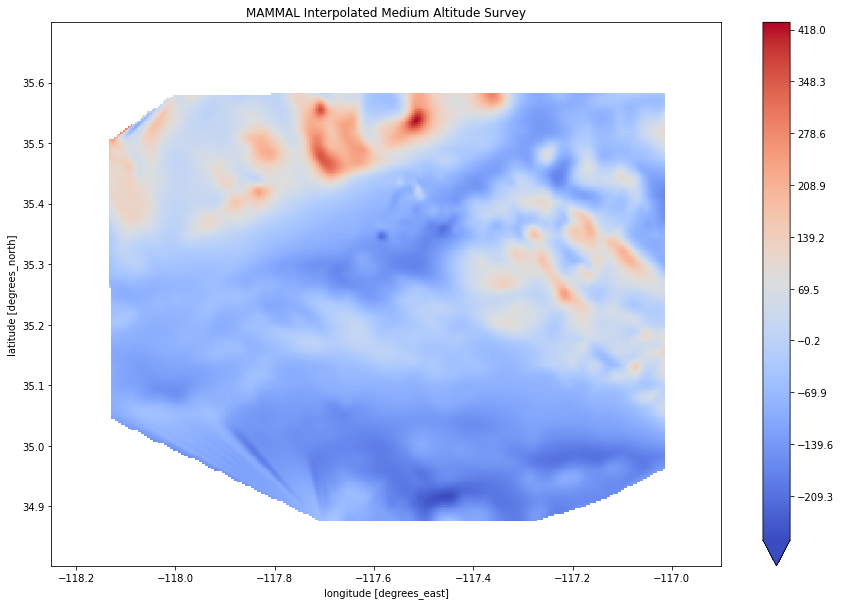

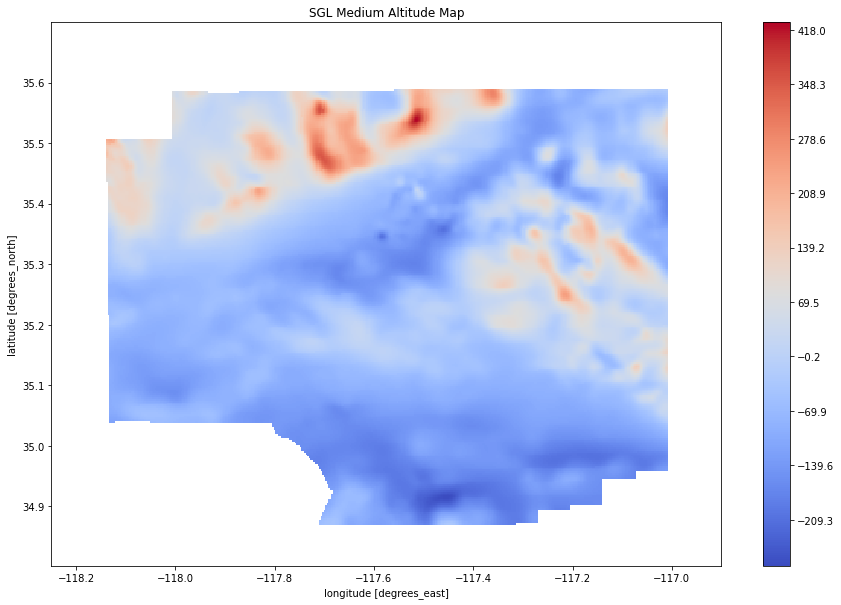

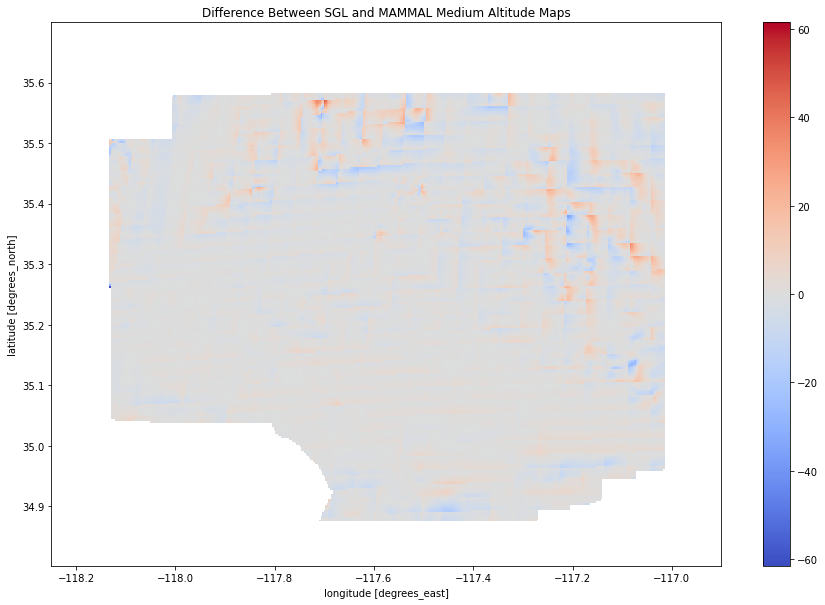

In [8]:
mammal_medium_map = mammal_medium_map.interp(x=medium_map.x, y=medium_map.y)

plt.figure()
mammal_medium_map[0].plot(cmap=cm.coolwarm, levels=medium_lvls)
plt.title('MAMMAL Interpolated Medium Altitude Survey')

plt.figure()
medium_map.plot(cmap=cm.coolwarm, levels=medium_lvls)
plt.title('SGL Medium Altitude Map')

plt.figure()
(medium_map[0] - mammal_medium_map[0]).plot(cmap=cm.coolwarm)
plt.title('Difference Between SGL and MAMMAL Medium Altitude Maps')

# Load and Plot SGL Raw Survey Data - Cap Altitude

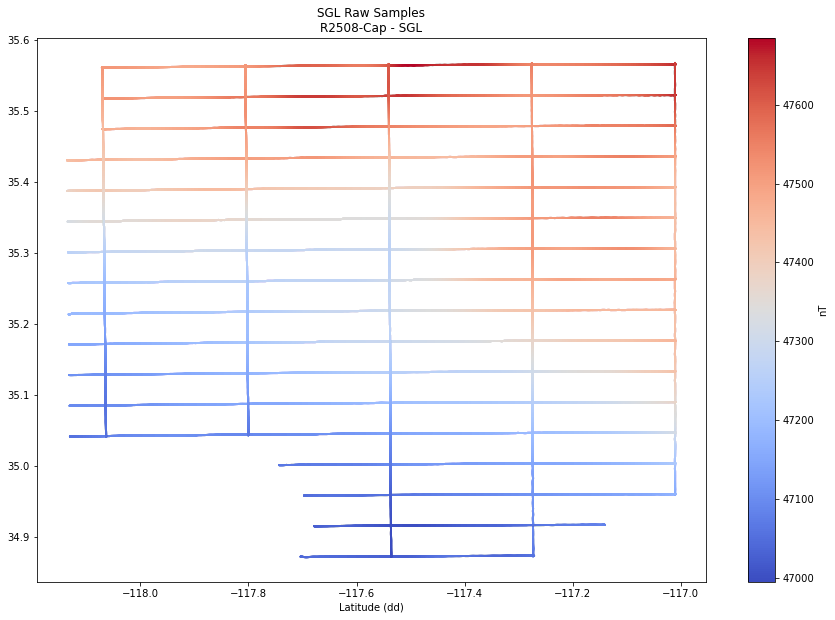

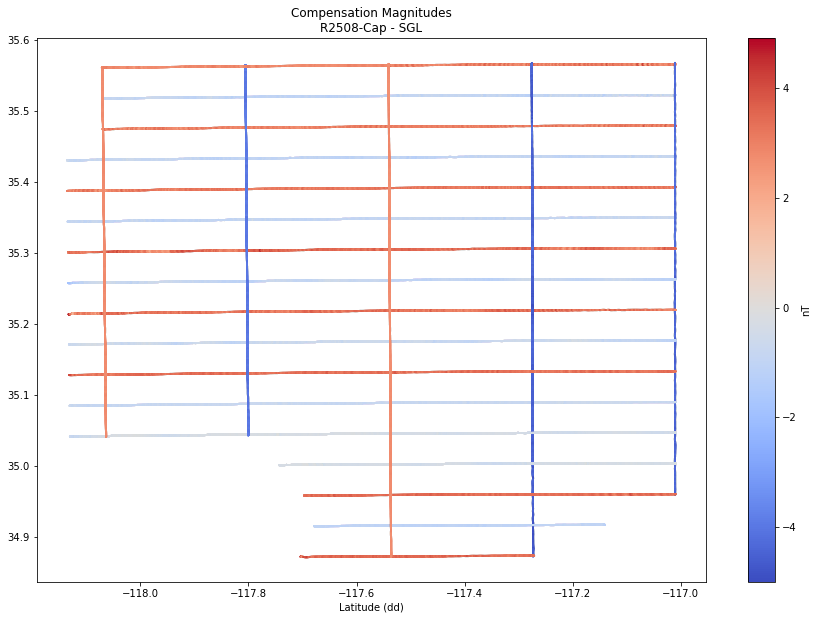

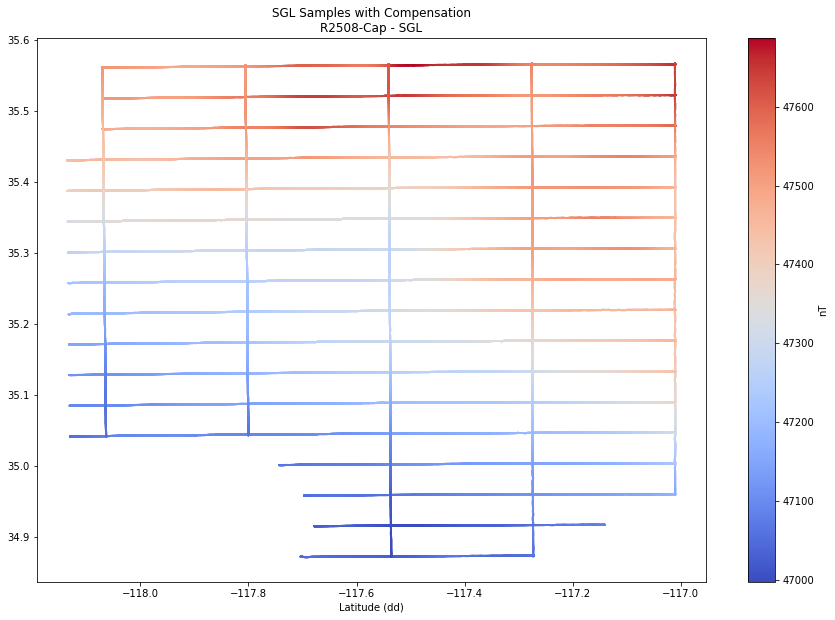

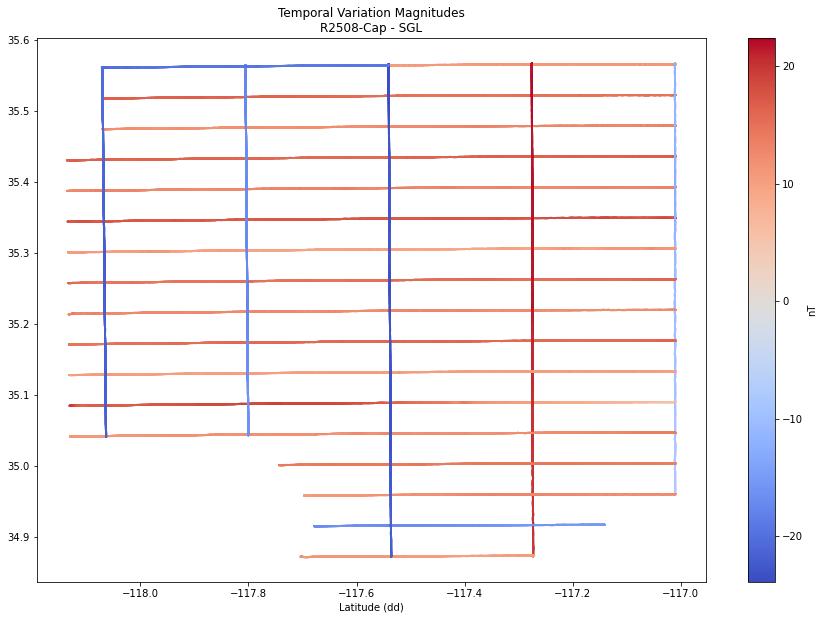

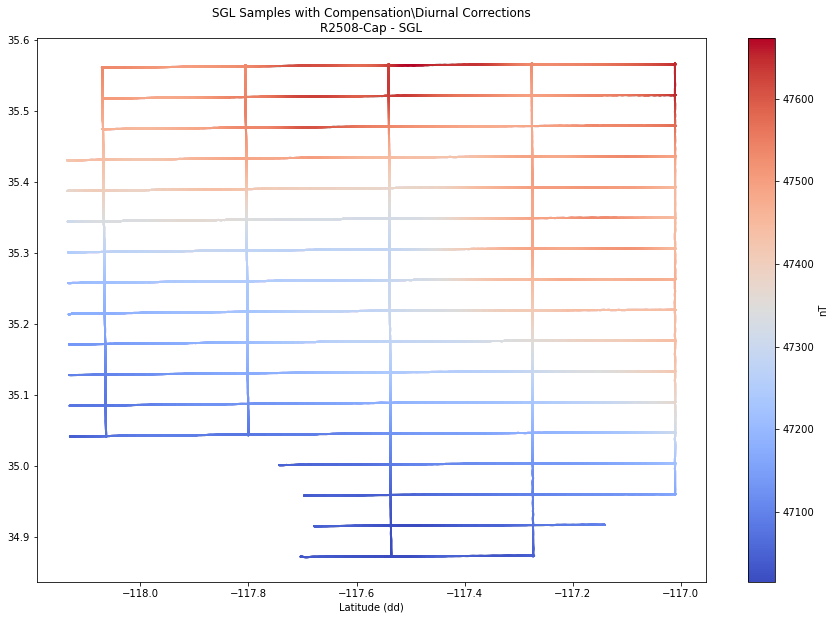

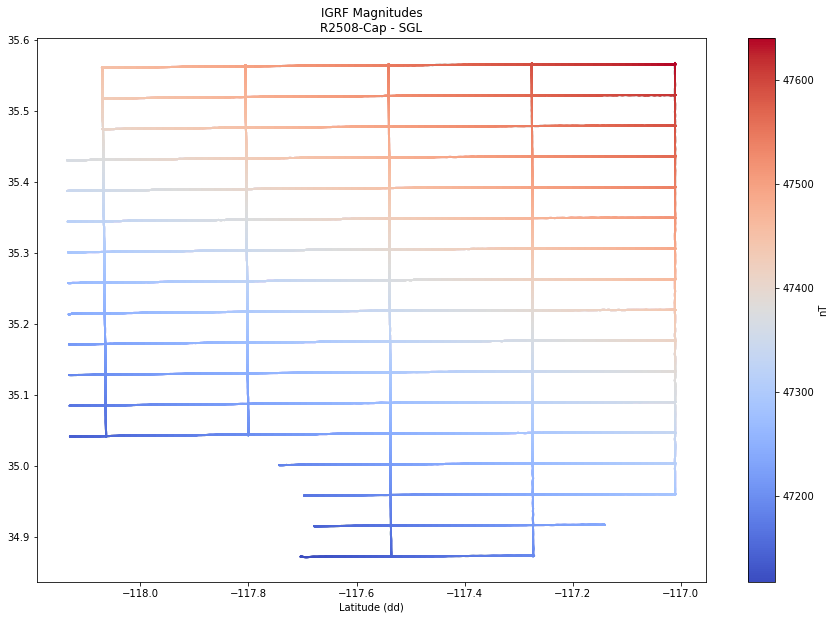

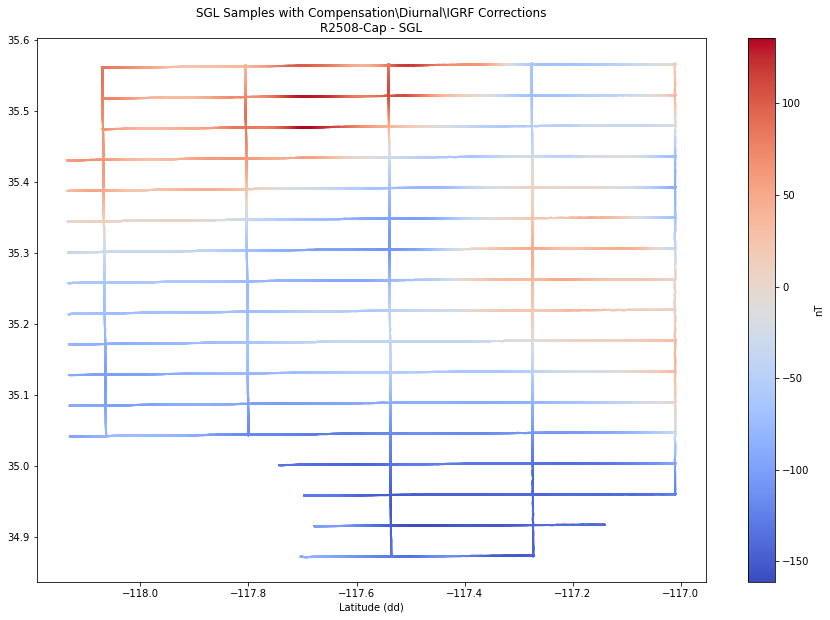

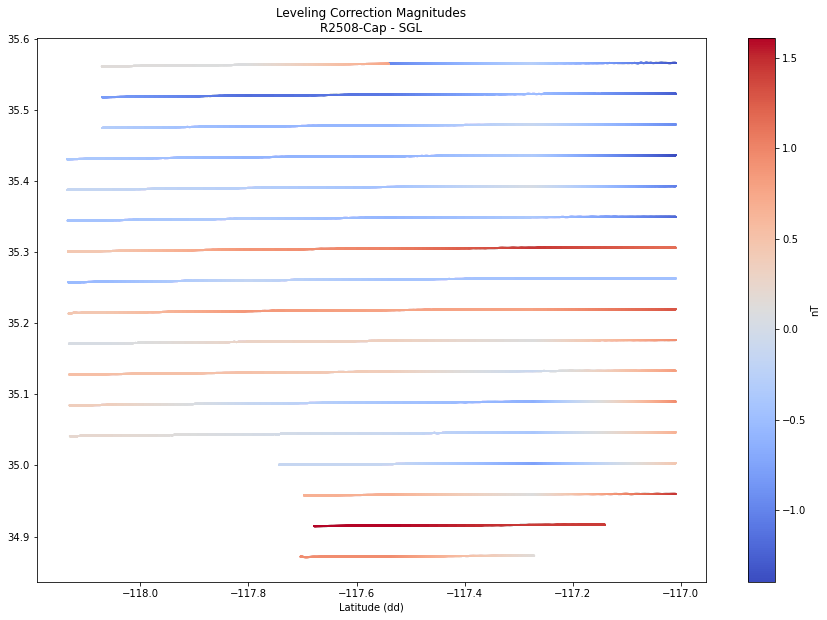

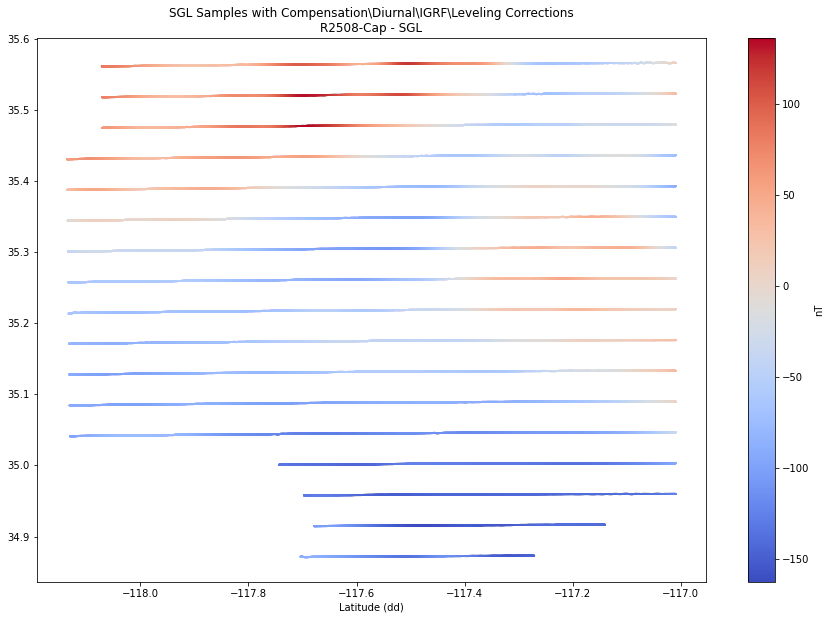

In [9]:
cap_df = psgl.parse_xyz(CAP_SURVEY_FNAME)

cap_df.rename(columns={'LVLDMAG': 'F'},
              inplace=True)

cap_df['ALT']       = 0
cap_df['LINE_TYPE'] = 2
cap_df.LINE_TYPE[((cap_df.AZIMUTH >= 75)  & (cap_df.AZIMUTH <= 105)) | \
                 ((cap_df.AZIMUTH >= 250) & (cap_df.AZIMUTH <= 280))] = 1

init_xyz_plots(cap_df, CAP_SURVEY_NAME)

# MAMMAL Interpolate SGL Raw Data - Cap Altitude

In [10]:
cap_interp_dict = pu.interp_flight_lines(anomaly_df      = cap_df,
                                         dx              = abs(np.mean(np.diff(cap_map_tm.x))),
                                         dy              = abs(np.mean(np.diff(cap_map_tm.y))),
                                         max_terrain_msl = 0,
                                         interp_type     = 'bicubic',
                                         skip_na_mask    = True)

mammal_cap_map = mu.export_map(TEST_DIR,
                               CAP_SURVEY_NAME + '_mammal',
                               cap_df.datetime[0],
                               np.sort(np.unique(cap_interp_dict['LAT'])),
                               np.sort(np.unique(cap_interp_dict['LONG'])),
                               cap_interp_dict['F'],
                               0)

Interpolating survey anomaly data to map coordinates
Running bicubic spline interpolation for all map pixels


# Compare MAMMAL Interpolated Map Vs SGL Map - Cap Altitude

C:\Users\ltber\Anaconda3\Lib\site-packages\xarray\core\missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
C:\Users\ltber\Anaconda3\Lib\site-packages\xarray\core\missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
C:\Users\ltber\Anaconda3\Lib\site-packages\xarray\core\missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
C:\Users\ltber\Anaconda3\Lib\site-packages\xarray\core\missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. 

Text(0.5, 1.0, 'Difference Between SGL and MAMMAL Cap Altitude Maps')

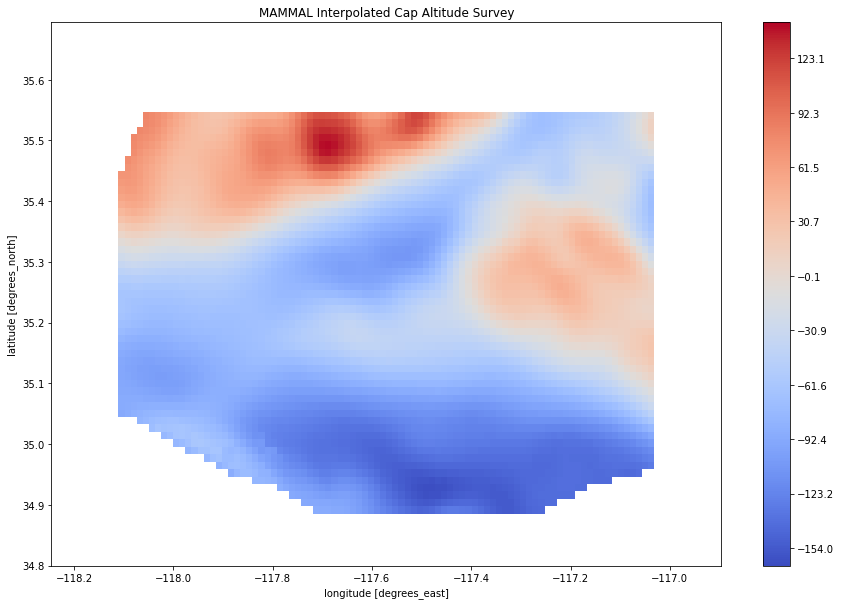

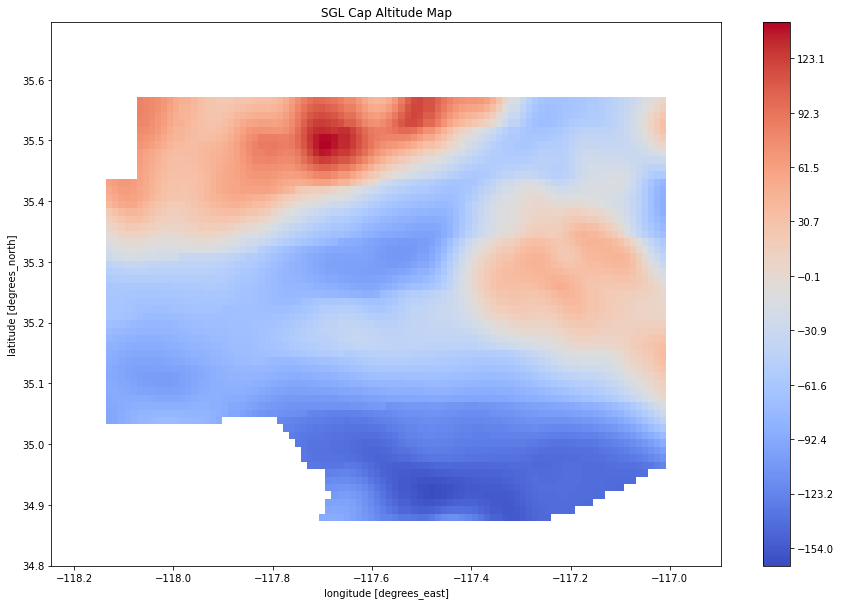

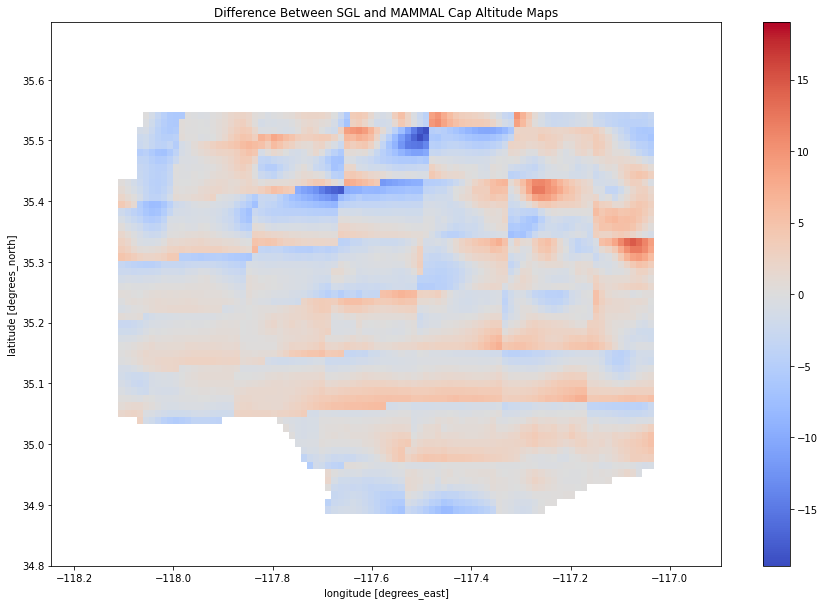

In [11]:
mammal_cap_map = mammal_cap_map.interp(x=cap_map.x, y=cap_map.y)

plt.figure()
mammal_cap_map[0].plot(cmap=cm.coolwarm, levels=cap_lvls)
plt.title('MAMMAL Interpolated Cap Altitude Survey')

plt.figure()
cap_map.plot(cmap=cm.coolwarm, levels=cap_lvls)
plt.title('SGL Cap Altitude Map')

plt.figure()
(cap_map[0] - mammal_cap_map[0]).plot(cmap=cm.coolwarm)
plt.title('Difference Between SGL and MAMMAL Cap Altitude Maps')